In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp
from numpy.linalg import inv
np.random.seed(8008)
import time
from tqdm import tqdm, trange

from scipy.integrate import odeint
from IPython.display import Latex

In [2]:
#Fix parameters
D_r = 500 #500
N = 4000  #2000
dt = 0.02
iterate = 10
t0 = 0
t1 = N*dt

In [3]:
#Lorenz system
def get_lorenz_vals(dt, ic):
    def lorenz1(xyz, t, s=10, r=28, b=8/3):
        x,y,z = xyz
        dx = s*(y - x)
        dy = r*x - y - x*z
        dz = x*y - b*z
        return np.array([dx,dy,dz])
    
    from scipy.integrate import odeint
    sol = odeint(lorenz1, ic, dt)
    xs,ys,zs = sol.T

    return sol.T

In [4]:
#Implement the Algorithm
def find_approximation(system: callable, t0: float, t1: float,
                       N=N, D_r=D_r, w=0.005, b=4, beta=1e-5): 
    ic = np.random.uniform(0, 5, (1,3))[0] #random initial condition from 0 to 5 every time
    U: np.ndarray = system(np.linspace(t0, t1, N+1), ic)
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = (1/np.sqrt(D_r))*np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = (1/np.sqrt(D_r))*np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    #U_pred = np.atleast_2d(U_hat[:, -1]).T # Further approximation starting from u_(n+1), will not be used in this experiment
    #for _ in range(N):
        #u_n = U_pred[:, -1]
        #phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        #u_np1 = W_LR @ phi
        #U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat, U_pred
    return U, U_hat#, U_pred

In [5]:
def find_tf(system, N, D_r, β, t0 = t0, t1 = t1):
    U, U_hat = find_approximation(system, t0, t1, N=N, D_r=D_r, beta = β)
    error = 0
    tf = 0
    n=0
    while error <= 0.05:
        error = (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
        tf += dt
        n += 1
    return tf

find_tf(get_lorenz_vals, N, D_r, 0.0000001)

5.1799999999999775

In [6]:
# For the case with noise
def find_approx_noise(system: callable, t0: float, t1: float,
                       N=N, D_r=D_r, w=0.005, b=4, beta=0.1):
    ic = np.random.uniform(0, 5, (1,3))[0]
    U: np.ndarray = system(np.linspace(t0, t1, N+1),ic)
    U = U + 0.2*np.random.normal(0, 1, np.shape(U)) # Noise in uniform distribution (-1,1) * 0.2
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = (1/np.sqrt(D_r))*np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = (1/np.sqrt(D_r))*np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    #U_pred = np.atleast_2d(U_hat[:, -1]).T
    #for _ in range(N):
        #u_n = U_pred[:, -1]
        #phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        #u_np1 = W_LR @ phi
        #U_pred = np.concatenate((U_pred, u_np1), axis=1)

    return U, U_hat#, U_pred

def find_tfnoise(system, N, D_r, β, t0 = t0, t1 = t1):
    U, U_hat = find_approx_noise(system, t0, t1, N=N, D_r=D_r, beta = β)
    error = 0
    tf = 0
    n=0
    while error <= 0.05:
        error = (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
        tf += dt
        n += 1
    return tf

In [ ]:
#small test for zero-noise case
β=np.array([1e-3,1e-4,1e-8,1e-9])
logβ = np.log10(β)

tf = np.zeros(len(logβ))
for i in trange(iterate):
    tf0 = []
    for b in β:
        tf0.append(find_tf(get_lorenz_vals, N, D_r, b))
    tf = tf + np.array(tf0)
tf = tf/iterate

plt.plot(logβ, tf)
plt.xlabel("$log_{10}β$")
plt.ylabel('$τ_f$')
plt.title("τ_f - logβ")
plt.savefig("test.jpg", dpi=150, bbox_inches='tight')

100%|██████████| 10/10 [02:27<00:00, 14.71s/it]


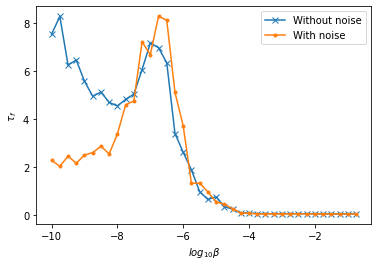

In [7]:
#Zero-noise and noise cases together
logβ = np.arange(-10,-0.5,0.25)
β=10**(logβ)

tf = np.zeros(len(β))
tfn = np.zeros(len(β))
for i in trange(iterate):
    tf0 = []
    tfn0 = []
    for b in β:
        tf0.append(find_tf(get_lorenz_vals, N, D_r, b))
        tfn0.append(find_tfnoise(get_lorenz_vals, N, D_r, b))
    tf = tf + np.array(tf0)
    tfn = tfn + np.array(tfn0)
tf = tf/iterate
tfn = tfn / iterate

plt.plot(logβ, tf, marker='x',label="Without noise")
plt.plot(logβ, tfn, marker='.',label="With noise")
plt.xlabel('$log_{10}β$')
plt.ylabel('$τ_f$')
plt.legend()
plt.savefig("test.jpg", dpi=150, bbox_inches='tight')

In [ ]:
#noise case
β2=np.array([1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9])
logβ2 = np.log10(β2)

tf2 = np.zeros(len(logβ2))
for i in range(iterate):
    tf0 = []
    for b in β2:
        tf0.append(find_tfnoise(get_lorenz_vals, N, D_r, b))
    tf2 = tf2 + np.array(tf0)
tf2 = tf2/iterate

plt.plot(logβ2, tf2, marker='x')

In [ ]:
type(Latex(r'$log_{10}\beta$'))

In [ ]:
Latex(r'$\tau_f$')